# Detecção de Alvos lineares em imagens de Sonar

## Imports

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage import filters
from skimage.filters import threshold_otsu, threshold_local, threshold_minimum

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Constants

In [3]:
IMAGE_PATH = "images/204145.png"
# IMAGE_PATH = "images/204146.png"

THRESHOLD_MORPHOLOGY = 250

## Load Image

In [4]:
raw_image = cv.imread(IMAGE_PATH)[:, :, 0]

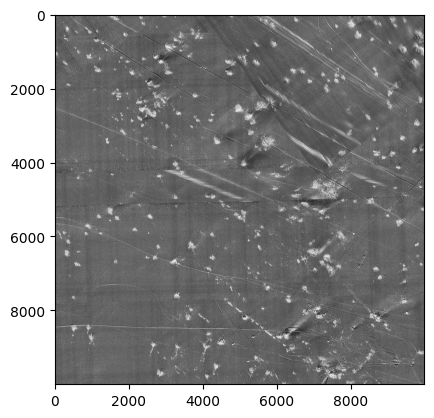

In [5]:
plt.imshow(raw_image, cmap = "gray")

In [6]:
raw_image.shape

(10000, 10000)

## Histogram Equalization

In [7]:
# from ipywidgets import interact_manual

# @interact_manual(kernel_size = (50, 5000, 50), clip_limit = (0.1, 1.0))
# def histogram_equalization_local(kernel_size, clip_limit):
#     global raw_image
#     cl1 = exposure.equalize_adapthist( raw_image, kernel_size = (kernel_size, kernel_size), clip_limit=clip_limit )
#     cl1 = (cl1*255).astype(np.uint8)
#     plt.imshow(cl1, cmap = "gray")

In [8]:
KERNEL_LEN = ( raw_image.shape[0] // 20, raw_image.shape[1] // 20 )
cl1 = exposure.equalize_adapthist( raw_image, kernel_size = KERNEL_LEN, clip_limit=1 )
cl1 = (cl1*255).astype(np.uint8)

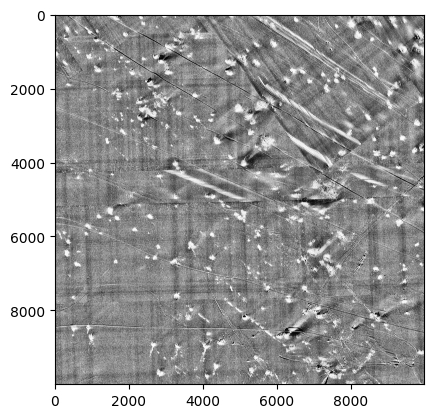

In [9]:
plt.imshow(cl1, cmap = "gray")

## Detect Horizontal Lines with Morphology

In [10]:
line_size = cl1.shape[1] // 500
print("Line Size:", line_size)

Line Size: 20


In [11]:
horizontal_structure = cv.getStructuringElement(cv.MORPH_RECT, (line_size, 1))

In [12]:
horizontal_structure

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=uint8)

In [13]:
horizontal = cv.dilate(cl1, horizontal_structure)
horizontal = cv.morphologyEx(horizontal, cv.MORPH_OPEN, horizontal_structure)

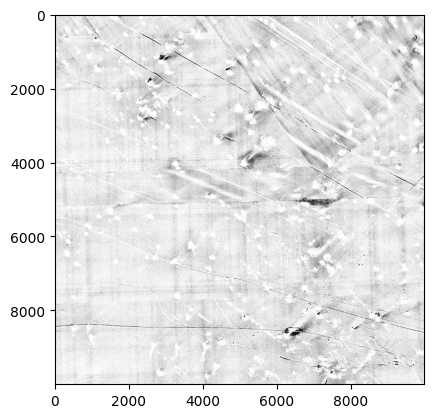

In [14]:
plt.imshow(horizontal, cmap = "gray")

In [15]:
horizontal.shape

(10000, 10000)

In [16]:
horizontal_threshold = (horizontal >= THRESHOLD_MORPHOLOGY).astype(np.uint8)

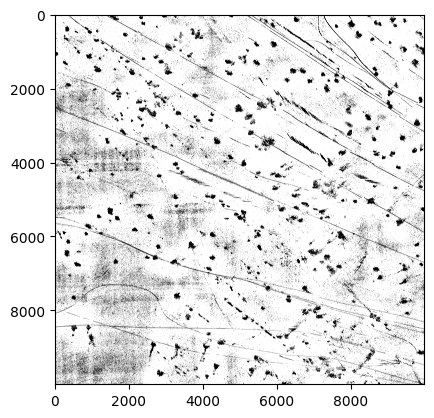

In [17]:
plt.imshow(horizontal_threshold, cmap = "binary")

## Detect Vertical Lines with Morphology

In [18]:
vertical_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, line_size))

In [19]:
vertical_structure

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [20]:
vertical = cv.dilate(cl1, vertical_structure)
vertical = cv.morphologyEx(vertical, cv.MORPH_OPEN, vertical_structure)

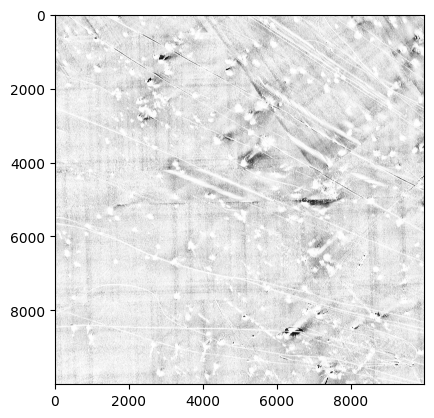

In [21]:
plt.imshow(vertical, cmap = "gray")

In [22]:
vertical_threshold = (vertical >= THRESHOLD_MORPHOLOGY).astype(np.uint8)

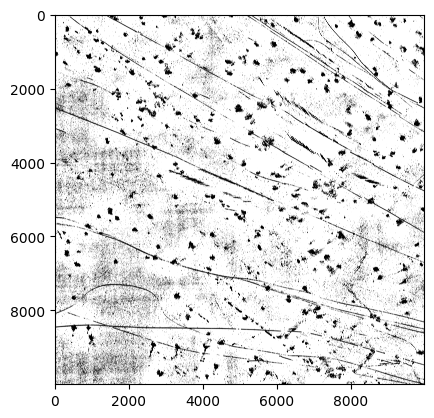

In [23]:
plt.imshow(vertical_threshold, cmap = "binary")

## Detect Diagonal Lines with Morphology

In [24]:
diagonal_structure_right = np.diag(np.ones(line_size)).astype(np.uint8)
diagonal_structure_left = np.fliplr(diagonal_structure_right)

In [25]:
diagonal_right = cv.dilate(cl1, diagonal_structure_right)
diagonal_right = cv.morphologyEx(diagonal_right, cv.MORPH_OPEN, diagonal_structure_right)

In [26]:
diagonal_right_threshold = (diagonal_right >= THRESHOLD_MORPHOLOGY).astype(np.uint8)

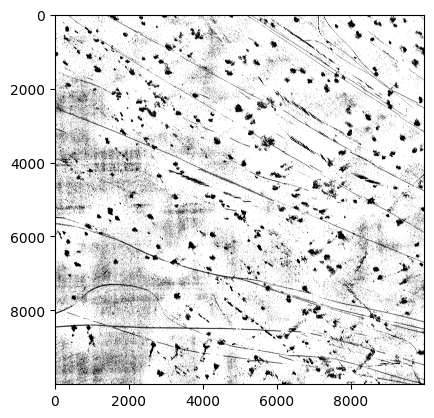

In [27]:
plt.imshow(diagonal_right_threshold, cmap = "binary")

In [28]:
diagonal_left = cv.dilate(cl1, diagonal_structure_left)
diagonal_left = cv.morphologyEx(diagonal_left, cv.MORPH_OPEN, diagonal_structure_left)

In [29]:
diagonal_left_threshold = (diagonal_left >= THRESHOLD_MORPHOLOGY).astype(np.uint8)

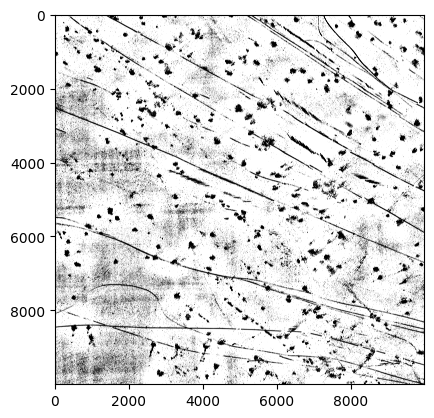

In [30]:
plt.imshow(diagonal_left_threshold, cmap = "binary")

## Union Detect Lines

In [31]:
lines_horizontal_vertical = cv.bitwise_or(horizontal_threshold, vertical_threshold)
lines_diagonal = cv.bitwise_or(diagonal_left_threshold, diagonal_right_threshold)
lines_raw = cv.bitwise_or(lines_horizontal_vertical, lines_diagonal)

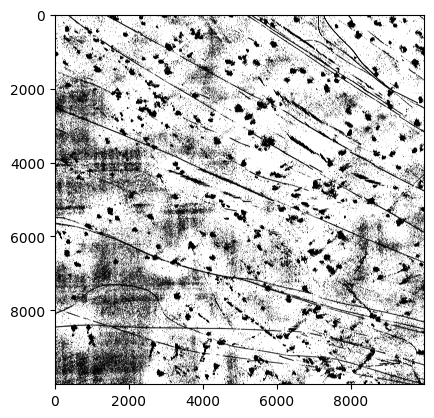

In [32]:
plt.imshow(lines_raw, cmap = "binary")

In [33]:
kernel = np.ones((5,5), np.uint8)
lines_threshold = cv.morphologyEx(lines_raw, cv.MORPH_OPEN, kernel, iterations = 2)

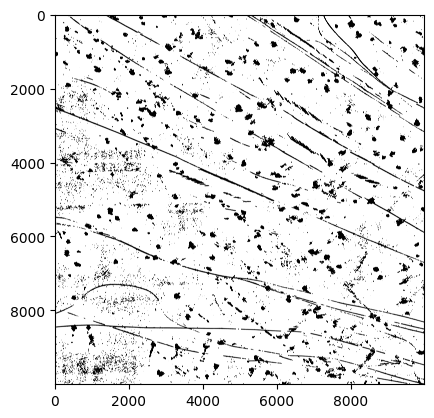

In [34]:
plt.imshow(lines_threshold, cmap = "binary")

## TO-DO
1. Testar equalização de histograma local com scikit-image
2. Após a transformada de hough, aplicar análise de componentes conexas
3. Manter somente objetos que tem maior length

In [35]:
# Análise de componentes conexas
label_image = label(lines_threshold)

In [36]:
# plt.imshow( label2rgb(label_image, bg_label=0) )

## Detect only lines

### Case 1 - Detectar somente linhas lineares a partir de eccentricidade, eixo maior e eixo menor

In [37]:
# # Filtrar linhas baseadas em propriedades geométricas
# # Ajuste os valores de limiar conforme necessário
# min_eccentricity = 0.90  # Linhas tendem a ter alta excentricidade
# min_major_axis_length = 50  # Ajuste baseado no tamanho esperado das linhas
# max_minor_axis_length = 300  # Linhas devem ser estreitas\\\\

# # Propriedades dos componentes conectados
# properties = regionprops(label_image)

# for prop in properties:
#     if (prop.eccentricity > min_eccentricity and 
#         prop.major_axis_length > min_major_axis_length and 
#         prop.minor_axis_length < max_minor_axis_length
#        ):
#         # Marcar o componente como linha
#         lines_mask[label_image == prop.label] = 1

In [38]:
# # Mostrar a imagem original e a imagem com as linhas identificadas
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(lines_threshold, cmap='gray')
# ax[0].set_title('Imagem Binária')
# ax[0].axis('off')

# ax[1].imshow(lines_mask, cmap='gray')
# ax[1].set_title('Linhas Identificadas')
# ax[1].axis('off')

# plt.show()

### Case 2 - Detectar objetos lineares e arredondados a partir de características de geometria

In [39]:
# Propriedades dos componentes conectados
properties = regionprops(label_image)

In [40]:
# # Parâmetros ajustáveis
# MIN_WIDTH = 50 # Largura minima
# ROUNDNESS_THRESHOLD = 0.05  # Limite de arredondamento para objetos arredondados
# LINEAR_ASPECT_RATIO_THRESHOLD = 1.02  # Limite de razão de aspecto para objetos lineares
# EXTENSION_THRESHOLD = 3.0  # Limite de extensão para objetos lineares
# AREA_WIDTH_HEIGHT_THRESHOLD = 0.25 # Limite da area em relação a altura e largura do objeto

In [79]:
# Parâmetros ajustáveis
MIN_WIDTH = 50 # Largura minima
ROUNDNESS_THRESHOLD = 0.05  # Limite de arredondamento para objetos arredondados
LINEAR_ASPECT_RATIO_THRESHOLD = 1.01  # Limite de razão de aspecto para objetos lineares
EXTENSION_THRESHOLD = 2.0  # Limite de extensão para objetos lineares
AREA_WIDTH_HEIGHT_THRESHOLD = 0.4 # Limite da area em relação a altura e largura do objeto

In [80]:
lines_mask = np.zeros_like(raw_image)

#### Elongation e Roundness com Análise de componenetes conexas (Scikit-Imagem)

In [81]:
# Processar cada região
for region in properties:
    # Calcular a bounding box e as características geométricas
    minr, minc, maxr, maxc = region.bbox
    width = maxc - minc
    height = maxr - minr

    if width < MIN_WIDTH:
        continue

    # Calcular a razão de aspecto (invariante à orientação)
    if height > 0:
        aspect_ratio = width / height
    else:
        aspect_ratio = 0

    # Calcular a arredondamento
    if region.perimeter > 0:
        roundness = (4 * np.pi * region.area) / (region.perimeter ** 2)
    else:
        roundness = 0

    # Calcular a extensão (elongation)
    if region.perimeter > 0:
        extension = region.area / region.perimeter
    else:
        extension = 0

    # Area em relação a altura e largura do objeto
    area_width_height = region.area / (width * height)

    # Definir limiares para classificar objetos arredondados e lineares
    if \
        (aspect_ratio >= LINEAR_ASPECT_RATIO_THRESHOLD) and \
        (extension >= EXTENSION_THRESHOLD) and \
        (roundness < ROUNDNESS_THRESHOLD) and \
        (area_width_height < AREA_WIDTH_HEIGHT_THRESHOLD):
        # Objeto linear
        lines_mask[label_image == region.label] = 1
    else:
        # Outro objeto
        lines_mask[label_image == region.label] = 2

In [82]:
lines_mask_rgb = label2rgb(lines_mask, colors = [(255, 0, 0), (255, 255, 255)]).astype(np.uint8)
lines_mask_binary = np.where(lines_mask == 1, 255, 0).astype(np.uint8)

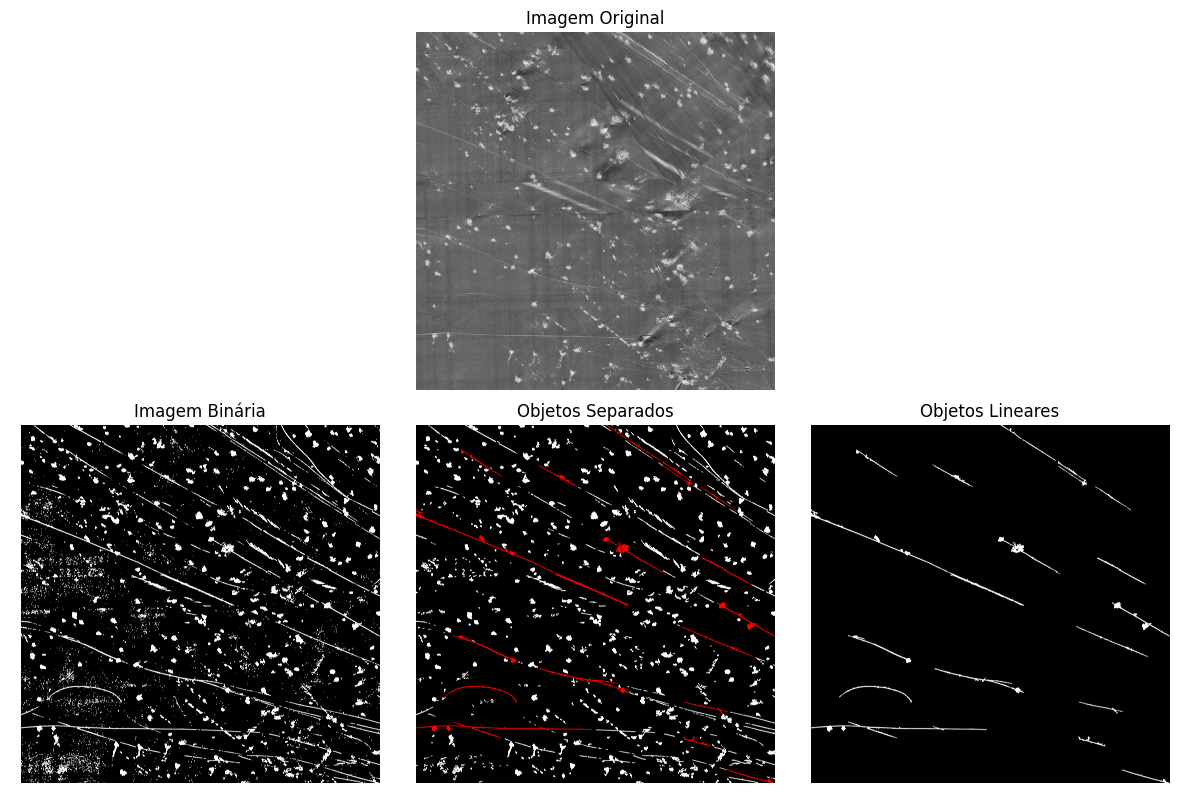

In [83]:
# Mostrar a imagem original, imagem binária, objetos separados e objetos lineares
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0][1].imshow(raw_image, cmap='gray')
ax[0][1].set_title('Imagem Original')
ax[0][1].axis('off')
ax[0][0].axis('off')
ax[0][2].axis('off')

ax[1][0].imshow(lines_threshold, cmap='gray')
ax[1][0].set_title('Imagem Binária')
ax[1][0].axis('off')

ax[1][1].imshow(lines_mask_rgb)
ax[1][1].set_title('Objetos Separados')
ax[1][1].axis('off')

ax[1][2].imshow(lines_mask_binary, cmap = "gray")
ax[1][2].set_title('Objetos Lineares')
ax[1][2].axis('off')

plt.tight_layout()
plt.show()

In [84]:
teste = cv.morphologyEx(lines_mask_binary, cv.MORPH_ERODE, horizontal_structure)

In [85]:
teste = cv.morphologyEx(teste, cv.MORPH_ERODE, vertical_structure)

In [86]:
teste = cv.morphologyEx(teste, cv.MORPH_ERODE, diagonal_structure_right)

In [87]:
teste = cv.morphologyEx(teste, cv.MORPH_ERODE, diagonal_structure_left)

In [88]:
kernel_circle = cv.getStructuringElement(cv.MORPH_RECT, (71,71))
teste = cv.morphologyEx(teste, cv.MORPH_DILATE, kernel_circle)

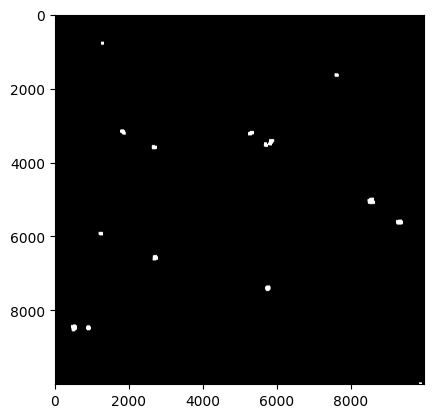

In [89]:
plt.imshow(teste, cmap = "binary_r")

In [90]:
lines_without_circle = lines_mask_binary * cv.bitwise_not(teste)

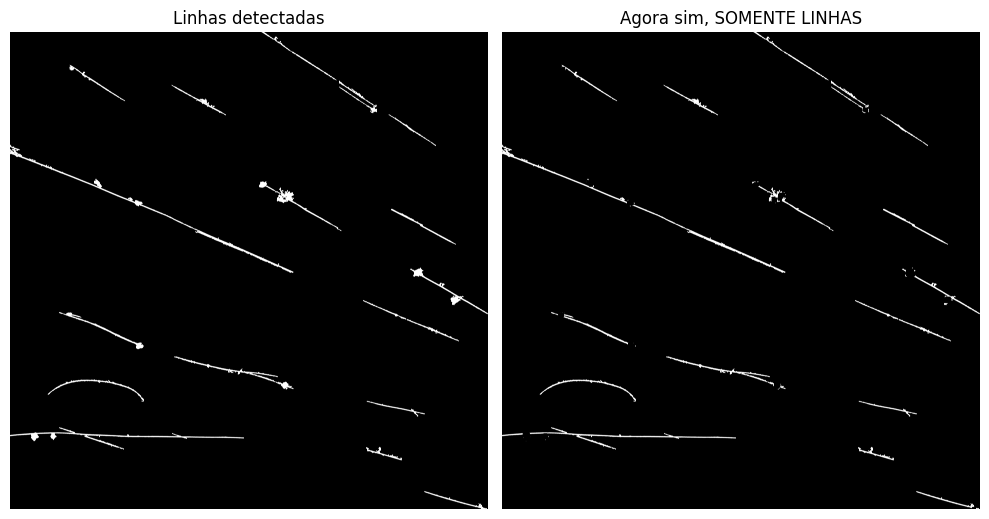

In [91]:
# Mostrar a imagem original, imagem binária, objetos separados e objetos lineares
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].imshow(lines_mask_binary, cmap='gray')
ax[0].set_title('Linhas detectadas')
ax[0].axis('off')

ax[1].imshow(lines_without_circle, cmap='gray')
ax[1].set_title('Agora sim, SOMENTE LINHAS')
ax[1].axis('off')

plt.tight_layout()
plt.show()